### Fashion MNIST

#### To be precise, Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.
- Folder path of train and test data

In [165]:
TRAIN_DATA_FOLDER_PATH = "./fashion_mnist/train-images-idx3-ubyte"
TRAIN_LABEL_FOLDER_PATH = "./fashion_mnist/train-labels-idx1-ubyte"
TEST_DATA_FOLDER_PATH =  "./fashion_mnist/t10k-images-idx3-ubyte"
TEST_LABEL_FOLDER_PATH = "./fashion_mnist/t10k-labels-idx1-ubyte"

- We use the following function to read the data (in ubyte form) and return it as a numpy array

In [166]:
import struct
import numpy as np

def read_idx(filename):
    """Credit: https://gist.github.com/tylerneylon"""
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [167]:
def read_image_data(TRAIN_DATA_FOLDER_PATH, TRAIN_LABEL_FOLDER_PATH, 
                    TEST_DATA_FOLDER_PATH, TEST_LABEL_FOLDER_PATH):
    
    x_train = read_idx(TRAIN_DATA_FOLDER_PATH)
    y_train = read_idx(TRAIN_LABEL_FOLDER_PATH)
    x_test = read_idx(TEST_DATA_FOLDER_PATH)
    y_test = read_idx(TEST_LABEL_FOLDER_PATH)
    
    return (x_train, y_train, x_test, y_test)

In [168]:
x_train, y_train, x_test, y_test = read_image_data(TRAIN_DATA_FOLDER_PATH, 
                                                   TRAIN_LABEL_FOLDER_PATH, 
                                                   TEST_DATA_FOLDER_PATH, 
                                                   TEST_LABEL_FOLDER_PATH)

print("Initial shape or dimensions of x_train", str(x_train.shape))
print ("Labels in y_train:" + str(y_train.shape))
print()
print("Initial shape or dimensions of x_test", str(x_test.shape))
print ("Labels in y_test:" + str(y_test.shape))

Initial shape or dimensions of x_train (60000, 28, 28)
Labels in y_train:(60000,)

Initial shape or dimensions of x_test (10000, 28, 28)
Labels in y_test:(10000,)


### Plot some random images, say 6 images, from train dataset  

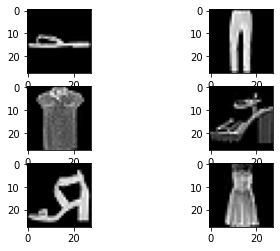

In [169]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=2)

for row in ax:
    for col in row:
        random_num = np.random.randint(0,len(x_train))
        col.imshow(x_train[random_num], cmap=plt.get_cmap('gray'))

In [170]:
def reshape_data(x_train, x_test):
    
    # Lets store the number of rows and columns
    img_rows = x_train[0].shape[0]
    img_cols = x_train[1].shape[0]

    # Getting our date in the right 'shape' needed for Keras
    # We need to add a 4th dimenion to our date thereby changing our
    # Our original image shape of (60000,28,28) to (60000,28,28,1)
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    
    # store the shape of a single image 
    input_shape = (img_rows, img_cols, 1)
    
    return x_train, x_test, input_shape

In [171]:
def normalize_data(x_train, x_test):
    
    # change our image type to float32 data type
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')

    # Normalize our data by changing the range from (0 to 255) to (0 to 1)
    x_train /= 255
    x_test /= 255
    
    return x_train, x_test

### Building CNN model 
- 2 Conv Layers and 1 Flatten Layer
- BatchNormalization
- Optimizer : Adadelta

In [172]:
from keras.datasets import mnist
from keras.utils import np_utils
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K

def cnn_model(input_shape, num_classes, optimizer = "Adadelta"):
    
    if optimizer == "Adadelta" :
        optimizer = keras.optimizers.Adadelta()
        
    
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss = 'categorical_crossentropy',
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    
    return model

In [173]:
# training parameters
batch_size = 128
epochs = 5

# reshape and normalize train and test data
x_reshape_train, x_reshape_test, input_shape = reshape_data(x_train, x_test)
x_norm_train, x_norm_test = normalize_data(x_reshape_train, x_reshape_test)


# one hot encode transformation on outputs
y_encode_train = np_utils.to_categorical(y_train)
y_encode_test = np_utils.to_categorical(y_test)


print ("Number of Classes: " + str(y_encode_train.shape[1]))

num_classes = y_encode_train.shape[1]

model = cnn_model(input_shape, num_classes, optimizer = "Adadelta")


history = model.fit(x_norm_train, y_encode_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_norm_test, y_encode_test))

score = model.evaluate(x_norm_test, y_encode_test, verbose=0)
print('Test loss : {}, Test accuracy: {}'.format(score[0], score[1]))

Number of Classes: 10
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 181s 3ms/step - loss: 0.4456 - accuracy: 0.8462 - val_loss: 2.4010 - val_accuracy: 0.3738
Epoch 2/5
60000/60000 [==============================] - 176s 3ms/step - loss: 0.2826 - accuracy: 0.9004 - val_loss: 0.2601 - val_accuracy: 0.9075
Epoch 3/5
60000/60000 [==============================] - 170s 3ms/step - loss: 0.2323 - accuracy: 0.9166 - val_loss: 0.2624 - val_accuracy: 0.9034
Epoch 4/5
60000/60000 [==============================] - 172s 3ms/step - loss: 0.2050 - accuracy: 0.9262 - val_loss: 0.2345 - val_accuracy: 0.9163
Epoch 5/5
60000/60000 [==============================] - 173s 3ms/step - loss: 0.1827 - accuracy: 0.9347 - val_loss: 0.2227 - val_accuracy: 0.9187
Test loss: 0.2226532601237297
Test accuracy: 0.9186999797821045


In [176]:
label = {0:"T-shirt/top ", 1:"Trouser", 2:"Pullover", 3:"Dress", 4:"Coat",
         5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}

def draw_test(name, pred, actual, input_im):
    
    BLACK = [0,0,0]
    
    res = label[int(pred)]
    actual = label[int(actual)]

    expanded_image = cv2.copyMakeBorder(input_im, 0, 0, 0, 4*imageL.shape[0] ,cv2.BORDER_CONSTANT,value=BLACK)
    expanded_image = cv2.cvtColor(expanded_image, cv2.COLOR_GRAY2BGR)
    cv2.putText(expanded_image, "Predicted - " + str(res), (152, 70) , cv2.FONT_HERSHEY_COMPLEX_SMALL,1, (0,255,0), 1)
    cv2.putText(expanded_image, "   Actual - " + str(actual), (152, 90) , cv2.FONT_HERSHEY_COMPLEX_SMALL,1, (0,0,255), 1)
    cv2.imshow(name, expanded_image)

In [177]:
import cv2

for i in range(0,10):
    rand = np.random.randint(0,len(x_test))
    input_im = x_norm_test[rand]
    actual = y_encode_test[rand].argmax(axis=0)
    imageL = cv2.resize(input_im, None, fx=4, fy=4, interpolation = cv2.INTER_CUBIC)
    input_im = input_im.reshape(1,28,28,1) 
    
    ## Get Prediction
    res = str(model.predict_classes(input_im, 1, verbose = 0)[0])
    
    draw_test("Prediction", res, actual, imageL) 
    cv2.waitKey(0)

cv2.destroyAllWindows()